In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
# --- 1. Préparation des données ---
print("1. Préparation des données...")

# Chargement et filtrage des données pour les marchés émergents
static_data = pd.read_excel("Static.xlsx")
em_firms = static_data[static_data['Region'] == 'EM']
em_isin_list = em_firms['ISIN'].tolist()

# Chargement des données
scope1 = pd.read_excel("Scope_1.xlsx")
scope2 = pd.read_excel("Scope_2.xlsx")
revenues = pd.read_excel("DS_REV_USD_Y.xlsx")
market_cap_m = pd.read_excel("DS_MV_T_USD_M.xlsx")
price_index_m = pd.read_excel("DS_RI_T_USD_M.xlsx")
risk_free_rates_df = pd.read_excel("Risk_Free_Rate.xlsx")

# Filtrage pour les marchés émergents
scope1_em = scope1[scope1['ISIN'].isin(em_isin_list)]
scope2_em = scope2[scope2['ISIN'].isin(em_isin_list)]
revenues_em = revenues[revenues['ISIN'].isin(em_isin_list)]
market_cap_m_em = market_cap_m[market_cap_m['ISIN'].isin(em_isin_list)]
price_index_m_em = price_index_m[price_index_m['ISIN'].isin(em_isin_list)]

print(f"Données filtrées pour les marchés émergents:")
print(f"Scope 1: {len(scope1_em)} entreprises")
print(f"Scope 2: {len(scope2_em)} entreprises")
print(f"Revenus: {len(revenues_em)} entreprises")
print(f"Market Cap (M): {len(market_cap_m_em)} entreprises")
print(f"Price Index (M): {len(price_index_m_em)} entreprises")

# --- 2. Traitement des données ---
# Fonction pour traiter les valeurs manquantes
def handle_missing_values(df):
    """
    Traite les valeurs manquantes entre deux valeurs connues en utilisant la valeur précédente.
    """
    # Créer une copie du dataframe
    df_result = df.copy()
    
    # Déterminer les colonnes d'années (les colonnes qui sont des entiers)
    year_columns = [col for col in df_result.columns if isinstance(col, int)]
    
    # Définir 'ISIN' comme index si ce n'est pas déjà le cas
    if 'ISIN' in df_result.columns:
        df_wide = df_result.set_index('ISIN')[year_columns].copy()
    else:
        df_wide = df_result[year_columns].copy()
    
    # Pour chaque ISIN
    for isin in df_wide.index:
        series = df_wide.loc[isin]
        non_nan_years = series.dropna().index.tolist()
        
        if len(non_nan_years) >= 2:
            # Trier les années
            non_nan_years.sort()
            
            # Pour chaque paire d'années consécutives avec des données
            for i in range(len(non_nan_years) - 1):
                current_year = non_nan_years[i]
                next_year = non_nan_years[i + 1]
                
                # Remplir les années intermédiaires avec la valeur de départ
                fill_value = df_wide.loc[isin, current_year]
                for year in range(current_year + 1, next_year):
                    if year in df_wide.columns:
                        df_wide.loc[isin, year] = fill_value
    
    return df_wide

# Traitement des valeurs manquantes
print("\n2. Traitement des valeurs manquantes...")
scope1_filled = handle_missing_values(scope1_em)
scope2_filled = handle_missing_values(scope2_em)
revenues_filled = handle_missing_values(revenues_em)

print("2.5 Conversion des données en type numérique...")
scope1_filled = scope1_filled.apply(pd.to_numeric, errors='coerce')
scope2_filled = scope2_filled.apply(pd.to_numeric, errors='coerce')
revenues_filled = revenues_filled.apply(pd.to_numeric, errors='coerce')
revenues_M = revenues_filled / 1000

# Calcul des émissions totales et de l'intensité carbone
print("3. Calcul de l'intensité carbone...")
total_emissions = scope1_filled.add(scope2_filled)
carbon_intensity = total_emissions/revenues_M # Revenus en million USD

# Préparation des rendements mensuels
print("4. Préparation des rendements mensuels...")

# Nettoyage et préparation des données prix
if 'NAME' in price_index_m_em.columns:
    price_index_m_em = price_index_m_em.drop(columns=['NAME'])

# Définir ISIN comme index pour les données de prix
price_index_m_clean = price_index_m_em.set_index('ISIN')

# Identifier les colonnes de dates dans le price_index
date_columns = [col for col in price_index_m_clean.columns if col not in ['ISIN', 'NAME']]

# Convertir les colonnes de dates en format datetime si nécessaire
date_mapping = {}
for col in date_columns:
    try:
        if isinstance(col, str):
            date_obj = pd.to_datetime(col, format='%d/%m/%Y')
            date_mapping[col] = date_obj.strftime('%Y-%m-%d')
    except:
        continue

# Renommer les colonnes si nécessaire
if date_mapping:
    price_index_m_clean = price_index_m_clean.rename(columns=date_mapping)
    # Trier les colonnes chronologiquement
    price_index_m_sorted = price_index_m_clean[sorted(price_index_m_clean.columns)]
else:
    # Si pas de renommage nécessaire, simplement trier les colonnes
    price_index_m_sorted = price_index_m_clean[sorted(price_index_m_clean.columns)]

# Calcul des rendements mensuels
returns_m = price_index_m_sorted.pct_change(axis=1,fill_method=None)
returns_m = returns_m.iloc[:, 1:]  # Supprimer la première colonne (NaN)

# Masquer les rendements basés sur des prix trop faibles

# --- 5. Masquage des rendements problématiques (prix trop faibles ou capitalisation insuffisante) ---
print("5. Masquage des rendements problématiques...")

# Nouveaux seuils plus restrictifs
price_threshold = 1.0   # 1$
cap_threshold = 100     # 100M$

# IMPORTANT: S'assurer que returns_m et price_index_m_sorted ont les mêmes dimensions
# Créer des copies pour travailler avec
returns_cleaned = returns_m.copy()
price_index_cleaned = price_index_m_sorted.copy()

# Pour chaque colonne de rendements
for col in returns_cleaned.columns:
    try:
        col_date = pd.to_datetime(col)
        
        # 1. Filtrer en fonction du prix
        # Trouver la colonne de prix la plus proche précédant cette date
        price_col = None
        min_diff = float('inf')
        
        for pcol in price_index_m_sorted.columns:
            try:
                pcol_date = pd.to_datetime(pcol)
                if pcol_date < col_date and (col_date - pcol_date).days < min_diff:
                    min_diff = (col_date - pcol_date).days
                    price_col = pcol
            except:
                continue
        
        if price_col is not None:
            # Masquer les rendements basés sur des prix trop faibles
            low_price_mask = price_index_m_sorted[price_col] < price_threshold
            returns_cleaned.loc[low_price_mask, col] = np.nan
        
        # 2. Filtrer en fonction de la capitalisation
        # Trouver la colonne de capitalisation la plus proche précédant cette date
        cap_col = None
        min_diff = float('inf')
        
        for ccol in market_cap_m_em.columns:
            if ccol not in ['ISIN', 'NAME']:
                try:
                    ccol_date = pd.to_datetime(ccol)
                    if ccol_date < col_date and (col_date - ccol_date).days < min_diff:
                        min_diff = (col_date - ccol_date).days
                        cap_col = ccol
                except:
                    continue
        
        if cap_col is not None:
            # Extraire les capitalisations
            if 'ISIN' in market_cap_m_em.columns:
                market_caps = market_cap_m_em.set_index('ISIN')[cap_col].copy()
            else:
                market_caps = market_cap_m_em[cap_col].copy()
            
            # Masquer les rendements basés sur des capitalisations trop faibles
            small_cap_mask = market_caps < cap_threshold
            common_idx = returns_cleaned.index.intersection(small_cap_mask.index)
            returns_cleaned.loc[common_idx[small_cap_mask.loc[common_idx]], col] = np.nan
            
    except Exception as e:
        print(f"Erreur lors du traitement de {col}: {e}")

# Masquer également les prix problématiques
price_index_cleaned[price_index_m_sorted < price_threshold] = np.nan

# Éliminer les rendements infinis
returns_cleaned = returns_cleaned.replace([np.inf, -np.inf], np.nan)

# Compter le nombre de valeurs masquées
original_values = returns_m.count().sum()
remaining_values = returns_cleaned.count().sum()
masked_values = original_values - remaining_values

print(f"5.2 Nettoyage des données de prix et capitalisation...")
print(f"Nombre de rendements masqués (prix < {price_threshold}$ ou cap < {cap_threshold}M$): {masked_values}")
print(f"Pourcentage de données conservées: {remaining_values/original_values*100:.1f}%")

# ---- Calcul du taux sans risque moyen annualisé ----
print("Calcul du taux sans risque moyen annualisé...")

# Définir la période d'évaluation (format YYYYMM)
eval_start_str = 201401  # Janvier 2014
eval_end_str = 202412    # Décembre 2024 (ou dernière date disponible)

# Filtrer les taux sans risque pour cette période
rf_eval_period = risk_free_rates_df[(risk_free_rates_df['Unnamed: 0'] >= eval_start_str) & 
                                   (risk_free_rates_df['Unnamed: 0'] <= eval_end_str)]
if len(rf_eval_period) > 0:
    # Convertir les taux mensuels de pourcentage à décimal
    monthly_rf_rates = rf_eval_period['RF'] / 100
    
    # Calculer le taux sans risque annualisé en utilisant la moyenne géométrique
    # (même convention que pour les rendements du portefeuille)
    cum_rf = (1 + monthly_rf_rates).prod() - 1
    T = len(monthly_rf_rates)
    annualized_rf_rate = ((1 + cum_rf) ** (12/T)) - 1
    
    
    print(f"Nombre de mois utilisés pour le calcul: {len(rf_eval_period)}")
    print(f"Taux sans risque annualisé: {annualized_rf_rate:.6f}")
else:
    raise ValueError("ERREUR: Aucune donnée de taux sans risque trouvée pour la période d'évaluation 2014-2024.")

1. Préparation des données...
Données filtrées pour les marchés émergents:
Scope 1: 710 entreprises
Scope 2: 710 entreprises
Revenus: 710 entreprises
Market Cap (M): 710 entreprises
Price Index (M): 710 entreprises

2. Traitement des valeurs manquantes...
2.5 Conversion des données en type numérique...
3. Calcul de l'intensité carbone...
4. Préparation des rendements mensuels...
5. Masquage des rendements problématiques...
5.2 Nettoyage des données de prix et capitalisation...
Nombre de rendements masqués (prix < 1.0$ ou cap < 100M$): 27248
Pourcentage de données conservées: 86.4%
Calcul du taux sans risque moyen annualisé...
Nombre de mois utilisés pour le calcul: 132
Taux sans risque annualisé: 0.015366


In [16]:
# Initialisation des dictionnaires pour stocker les résultats
all_optimal_weights_mv = {}
all_benchmark_weights_vw = {}
cf_mv_oos_annual = {}
cf_vw_annual = {}
monthly_returns_mv = {}
monthly_returns_vw = {}
waci_mv_annual = {}
waci_vw_annual = {}

# Fonction pour définir l'univers d'investissement avec filtre pour corrélations artificielles
def define_investment_universe(year, carbon_data, returns_data, price_data_cleaned, min_history_months=84, min_common_obs=30):
    """
    Définit l'univers d'investissement pour l'année year+1 en utilisant les informations disponibles en year.
    """
    # 1. Entreprises avec données carbone pour l'année year
    if year in carbon_data.columns:
        firms_with_carbon = carbon_data[carbon_data[year].notna()].index
        print(f"  · Entreprises avec données carbone pour {year}: {len(firms_with_carbon)}")
    else:
        print(f"  · Pas de données carbone pour {year}")
        return pd.Index([]), pd.Index([])
    
    # 2. Vérifier que l'entreprise est toujours active à la fin de l'année year
    end_date = None
    for col in price_data_cleaned.columns:
        try:
            col_date = pd.to_datetime(col)
            if col_date.year == year and col_date.month == 12:
                end_date = col
                break
        except:
            continue
    
    if end_date is None:
        print(f"  · Pas de données de prix pour décembre {year}")
        return pd.Index([]), pd.Index([])
    
    # Entreprises avec prix valide à la fin de l'année year
    active_firms = price_data_cleaned[end_date].dropna().index
    print(f"  · Entreprises avec prix valide en décembre {year}: {len(active_firms)}")
    
    # 3. Entreprises avec historique suffisant pour MV
    historical_cols = []
    for col in returns_data.columns:
        try:
            col_date = pd.to_datetime(col)
            if col_date <= pd.Timestamp(f"{year}-12-31"):
                historical_cols.append(col)
        except:
            continue
    
    # Trier les colonnes par ordre chronologique descendant
    historical_cols.sort(reverse=True)
    lookback_cols = historical_cols[:min_history_months]
    lookback_cols = sorted(lookback_cols)
    
    if len(lookback_cols) >= min_history_months:
        # Filtrer pour les entreprises avec données complètes
        candidate_firms = firms_with_carbon.intersection(active_firms)
        firms_with_complete_history = []
        
        for firm in candidate_firms:
            if firm in returns_data.index:
                firm_data = returns_data.loc[firm, lookback_cols]
                if firm_data.notna().all():
                    firms_with_complete_history.append(firm)
        
        firms_with_history = pd.Index(firms_with_complete_history)
        print(f"  · Entreprises avec données complètes pour les {min_history_months} mois: {len(firms_with_history)}")
    else:
        print(f"  · Pas assez de données historiques (seulement {len(lookback_cols)} mois disponibles)")
        firms_with_history = pd.Index([])
    
    # 4. Univers MV: intersection des trois ensembles
    universe_mv = firms_with_carbon.intersection(active_firms).intersection(firms_with_history)
    print(f"  · Univers MV initial pour investissement en {year+1}: {len(universe_mv)} entreprises")
    
    # NOUVEAU: Filtrer les titres avec peu de valeurs uniques
    if len(universe_mv) > 1:
        returns_subset = returns_data.loc[universe_mv, lookback_cols]
        
        # Calculer le nombre de valeurs uniques par titre
        unique_counts = {}
        excluded_tickers_examples = []
        for ticker in universe_mv:
            if ticker in returns_subset.index:
                # Compter les valeurs uniques non-NaN
                ticker_values = returns_subset.loc[ticker].dropna().values
                unique_counts[ticker] = len(np.unique(ticker_values))
        
        # Identifier les titres avec peu de valeurs uniques
        discrete_tickers = [ticker for ticker, count in unique_counts.items() if count <= 3]
        
        if discrete_tickers:
            # Afficher quelques exemples pour vérification
            examples_to_show = min(3, len(discrete_tickers))
            for i in range(examples_to_show):
                ticker = discrete_tickers[i]
                excluded_tickers_examples.append(f"{ticker} ({unique_counts[ticker]} valeurs uniques)")
            
            print(f"  · Titres exclus pour nombre limité de valeurs uniques (≤3): {len(discrete_tickers)}")
            print(f"    Exemples: {', '.join(excluded_tickers_examples)}")
            universe_mv = universe_mv.difference(discrete_tickers)
            print(f"  · Univers MV après filtrage des séries discrètes: {len(universe_mv)} entreprises")
            
            # IMPORTANT: Mettre à jour lookback_cols après le filtrage
            lookback_cols = returns_data.loc[universe_mv, lookback_cols].columns
    
    # 5. Détection et élimination des corrélations artificielles
    if len(universe_mv) > 1:
        returns_subset = returns_data.loc[universe_mv, lookback_cols]
        problematic_tickers = set()
        
        for i, ticker1 in enumerate(universe_mv):
            for j in range(i+1, len(universe_mv)):
                ticker2 = universe_mv[j]
                series1 = returns_subset.loc[ticker1]
                series2 = returns_subset.loc[ticker2]
                common_valid = (~series1.isna() & ~series2.isna()).sum()
                
                if common_valid < min_common_obs:
                    if common_valid >= 2:
                        mask = ~series1.isna() & ~series2.isna()
                        if mask.sum() >= 2:
                            corr = series1[mask].corr(series2[mask])
                            if abs(corr) > 0.9:
                                problematic_tickers.add(ticker1)
                                problematic_tickers.add(ticker2)
        
        if problematic_tickers:
            print(f"  · Titres exclus pour corrélations potentiellement artificielles: {len(problematic_tickers)}")
            universe_mv = universe_mv.difference(problematic_tickers)
            print(f"  · Univers MV après filtrage des corrélations artificielles: {len(universe_mv)} entreprises")
            
            # IMPORTANT: Mettre à jour lookback_cols après le filtrage
            lookback_cols = returns_data.loc[universe_mv, lookback_cols].columns
    
    # 6. Univers VW: intersection de deux ensembles
    universe_vw = firms_with_carbon.intersection(active_firms)
    print(f"  · Univers VW pour investissement en {year+1}: {len(universe_vw)} entreprises")
    
    return universe_mv, universe_vw, lookback_cols  # Retourner lookback_cols mis à jour

# Fonction pour optimiser le portefeuille à variance minimale
def portfolio_variance(weights, cov_matrix):
    return weights @ cov_matrix @ weights

# Paramètres
ridge_param = 0.30
max_iterations = 1000
optimizer_tolerance = 1e-9
start_year_rebalance = 2013
end_year_rebalance = 2023

# Boucle principale pour la construction des portefeuilles
for year_y in range(start_year_rebalance, end_year_rebalance + 1):
    print(f"\n=== Allocation pour {year_y+1} (données ≤ {year_y}) ===")
    
    # 1) Univers d'investissement
    universe_mv, universe_vw, lookback_cols = define_investment_universe(
        year_y,
        carbon_intensity,
        returns_cleaned,
        price_index_cleaned,
        min_history_months=84,
        min_common_obs=30
    )
    
    # 2) Extraction des rendements historiques
    end_date = pd.to_datetime(f"{year_y}-12-31")
    start_date = pd.to_datetime(f"{year_y-10+1}-01-01")
    hist_cols = [col for col in returns_cleaned.columns
                if start_date <= pd.to_datetime(col) <= end_date]
    
    returns_hist = returns_cleaned.loc[universe_mv, hist_cols]
    
    # 3) Calcul de la matrice de covariance avec régularisation ridge
    returns_for_cov = returns_hist.T
    # Utiliser min_periods pour garantir des estimations fiables
    cov_matrix = returns_for_cov.cov(ddof=0, min_periods=24)
    
    # Vérifier si la matrice contient des NaN sur la diagonale (variances)
    if np.any(np.isnan(np.diag(cov_matrix))):
        # Identifier les titres avec variance NaN
        nan_variance_tickers = []
        for i in range(len(cov_matrix)):
            if np.isnan(cov_matrix.iloc[i, i]):
                nan_variance_tickers.append(cov_matrix.index[i])
        
        print(f"  · Titres avec variance NaN: {len(nan_variance_tickers)}")
        
        # Exclure ces titres de l'univers et recalculer tout
        if nan_variance_tickers:
            universe_mv = universe_mv.difference(nan_variance_tickers)
            returns_hist = returns_cleaned.loc[universe_mv, hist_cols]
            returns_for_cov = returns_hist.T
            cov_matrix = returns_for_cov.cov(ddof=0, min_periods=24)
            print(f"  · Univers MV après exclusion des variances NaN: {len(universe_mv)} entreprises")
    
    # Vérifier si la matrice contient encore des NaN ailleurs
    if cov_matrix.isna().any().any():
        nan_count = cov_matrix.isna().sum().sum()
        print(f"  · Matrice de covariance contient {nan_count} valeurs NaN hors diagonale")
        
        # Remplacer les NaN hors diagonale par 0 (hypothèse d'indépendance)
        for i in range(len(cov_matrix)):
            for j in range(len(cov_matrix)):
                if i != j and pd.isna(cov_matrix.iloc[i, j]):
                    cov_matrix.iloc[i, j] = 0
                    cov_matrix.iloc[j, i] = 0  # Symétrie
        
        print(f"  · NaN hors diagonale remplacés par 0 (hypothèse d'indépendance)")
    
    sigma_bar = np.trace(cov_matrix) / len(cov_matrix)
    lambda_ = ridge_param * sigma_bar
    cov_matrix_reg = cov_matrix + np.eye(len(cov_matrix)) * lambda_
    
    kappa = np.linalg.cond(cov_matrix_reg)
    bias_ratio = lambda_ / sigma_bar
    
    print(f"  · cond(Σ régularisée): {kappa:.2e}")
    print(f"  · Biais relatif (λ/σ̄²): {bias_ratio:.1%}")
    
    # 4) Optimisation MV
    n_assets = len(cov_matrix)  # Recalculer après le nettoyage
    cons_mv = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds_mv = tuple((0, None) for _ in range(n_assets))  # Recalculer après le nettoyage
    init_guess = np.ones(n_assets) / n_assets  # Recalculer après le nettoyage
    
    try:
        opt_result = minimize(portfolio_variance, init_guess, args=(cov_matrix_reg,),
                            method='SLSQP', bounds=bounds_mv, constraints=cons_mv,
                            options={'ftol': optimizer_tolerance, 'maxiter': max_iterations})
        
        if opt_result.success:
            optimal_weights = pd.Series(opt_result.x, index=cov_matrix.index)
            optimal_weights[optimal_weights < 1e-8] = 0
            optimal_weights = optimal_weights / optimal_weights.sum()
            
            all_optimal_weights_mv[year_y] = optimal_weights
            nnz = (optimal_weights > 0).sum()
            print(f"  · Poids non nuls MV: {nnz}")
        else:
            print(f"  · Échec de l'optimisation: {opt_result.message}")
            all_optimal_weights_mv[year_y] = None
    except Exception as e:
        print(f"  · Erreur lors de l'optimisation: {e}")
        all_optimal_weights_mv[year_y] = None
    
    # 5) Calcul des poids du portefeuille pondéré par la valeur
    closest_date = None
    target_date = f"{year_y}-12-31"
    
    for col in market_cap_m_em.columns:
        if col not in ['ISIN', 'NAME']:
            try:
                col_date = pd.to_datetime(col)
                if closest_date is None or abs((col_date - pd.to_datetime(target_date)).days) < abs((pd.to_datetime(closest_date) - pd.to_datetime(target_date)).days):
                    closest_date = col
            except:
                continue
    
    if closest_date:
        market_cap_end = market_cap_m_em.set_index('ISIN')[closest_date] if 'ISIN' in market_cap_m_em.columns else market_cap_m_em[closest_date]
        
        market_cap_vw = market_cap_end[market_cap_end.index.isin(universe_vw)]
        total_cap = market_cap_vw.sum()
        
        if total_cap > 0:
            vw_weights = market_cap_vw / total_cap
            all_benchmark_weights_vw[year_y] = vw_weights
            nnz_vw = (vw_weights > 0).sum()
            print(f"  · Poids non nuls VW: {nnz_vw}")
        else:
            print(f"  · Capitalisation totale nulle pour {year_y}")
            all_benchmark_weights_vw[year_y] = None
    else:
        print(f"  · Pas de données de capitalisation pour {year_y}")
        all_benchmark_weights_vw[year_y] = None
    
    # 6) Calcul de la WACI des portefeuilles
    if year_y in carbon_intensity.columns and all_optimal_weights_mv[year_y] is not None:
        # WACI pour portefeuille MV
        mv_weights = all_optimal_weights_mv[year_y]
        intensity_y = carbon_intensity[year_y]
        common_assets = mv_weights.index.intersection(intensity_y.index)
        
        if len(common_assets) > 0:
            w_mv = mv_weights.loc[common_assets]
            ci_mv = intensity_y.loc[common_assets]
            valid_idx = ci_mv.notna()
            
            if valid_idx.any():
                w_valid = w_mv[valid_idx]
                ci_valid = ci_mv[valid_idx]
                w_valid = w_valid / w_valid.sum()
                waci_mv = (w_valid * ci_valid).sum()
                
                waci_mv_annual[year_y] = waci_mv
                print(f"  · WACI MV: {waci_mv:.4f}")
            else:
                waci_mv_annual[year_y] = np.nan
                print(f"  · Pas de données valides pour la WACI MV")
        else:
            waci_mv_annual[year_y] = np.nan
            print(f"  · Pas de données communes pour la WACI MV")
    
    # WACI pour portefeuille VW
    if year_y in carbon_intensity.columns and all_benchmark_weights_vw[year_y] is not None:
        vw_weights = all_benchmark_weights_vw[year_y]
        intensity_y = carbon_intensity[year_y]
        common_assets = vw_weights.index.intersection(intensity_y.index)
        
        if len(common_assets) > 0:
            w_vw = vw_weights.loc[common_assets]
            ci_vw = intensity_y.loc[common_assets]
            valid_idx = ci_vw.notna()
            
            if valid_idx.any():
                w_valid = w_vw[valid_idx]
                ci_valid = ci_vw[valid_idx]
                w_valid = w_valid / w_valid.sum()
                waci_vw = (w_valid * ci_valid).sum()
                
                waci_vw_annual[year_y] = waci_vw
                print(f"  · WACI VW: {waci_vw:.4f}")
            else:
                waci_vw_annual[year_y] = np.nan
                print(f"  · Pas de données valides pour la WACI VW")
        else:
            waci_vw_annual[year_y] = np.nan
            print(f"  · Pas de données communes pour la WACI VW")
    
    # 7) Calcul de l'empreinte carbone des portefeuilles
    if year_y in total_emissions.columns and all_optimal_weights_mv[year_y] is not None:
        # Empreinte carbone du portefeuille MV
        mv_weights = all_optimal_weights_mv[year_y]
        emissions_y = total_emissions[year_y]
        portfolio_value = 1  # 1 million USD
        common_assets = mv_weights.index.intersection(emissions_y.index)
        
        if len(common_assets) > 0 and market_cap_end is not None:
            w_mv = mv_weights.loc[common_assets]
            e_mv = emissions_y.loc[common_assets]
            cap_mv = market_cap_end.loc[common_assets]
            valid_idx = (e_mv.notna()) & (cap_mv > 0)
            
            if valid_idx.any():
                w_valid = w_mv[valid_idx]
                e_valid = e_mv[valid_idx]
                cap_valid = cap_mv[valid_idx]
                w_valid = w_valid / w_valid.sum()
                
                ownership = (w_valid * portfolio_value) / cap_valid
                cf_mv = (1 / portfolio_value) * np.sum(ownership * e_valid)
                
                cf_mv_oos_annual[year_y] = cf_mv
                print(f"  · Empreinte carbone MV: {cf_mv:.4f}")
            else:
                cf_mv_oos_annual[year_y] = np.nan
                print(f"  · Pas de données valides pour l'empreinte carbone MV")
        else:
            cf_mv_oos_annual[year_y] = np.nan
            print(f"  · Pas de données communes pour l'empreinte carbone MV")
    
    # Empreinte carbone du portefeuille VW
    if year_y in total_emissions.columns and all_benchmark_weights_vw[year_y] is not None:
        emissions_y = total_emissions[year_y]
        common_assets = emissions_y.index.intersection(market_cap_end.index)
        
        if len(common_assets) > 0:
            emissions_vw = emissions_y.loc[common_assets]
            cap_vw = market_cap_end.loc[common_assets]
            valid_idx = (emissions_vw.notna()) & (cap_vw > 0)
            
            if valid_idx.any():
                e_sum = emissions_vw[valid_idx].sum()
                cap_sum = cap_vw[valid_idx].sum()
                
                cf_vw = e_sum / cap_sum
                cf_vw_annual[year_y] = cf_vw
                print(f"  · Empreinte carbone VW: {cf_vw:.4f}")
            else:
                cf_vw_annual[year_y] = np.nan
                print(f"  · Pas de données valides pour l'empreinte carbone VW")
        else:
            cf_vw_annual[year_y] = np.nan
            print(f"  · Pas de données communes pour l'empreinte carbone VW")

# Calcul des rendements ex-post
print("\n=== Calcul des rendements ex-post ===")

# Période de performance
performance_start = pd.to_datetime("2014-01-01")
date_cols = [col for col in returns_cleaned.columns if pd.to_datetime(col) >= performance_start]
date_cols.sort()

if len(date_cols) > 0:
    # Initialiser les séries de rendements cumulés
    cum_returns_mv = pd.Series(index=date_cols, dtype=float)
    cum_returns_vw = pd.Series(index=date_cols, dtype=float)
    cum_returns_mv.iloc[0] = 1.0
    cum_returns_vw.iloc[0] = 1.0
    
    # Préparer market_cap pour faciliter l'accès
    if 'ISIN' in market_cap_m_em.columns:
        market_cap_clean = market_cap_m_em.set_index('ISIN').copy()
    else:
        market_cap_clean = market_cap_m_em.copy()
    
    # Pour chaque année de performance
    for year_perf in range(2014, 2025):
        # Identifier l'année d'allocation précédente
        year_alloc = year_perf - 1
        
        # Récupérer les poids pour cette allocation MV
        mv_weights = all_optimal_weights_mv.get(year_alloc)
        
        # Colonnes (mois) pour cette année de performance
        perf_cols = [col for col in date_cols 
                    if pd.to_datetime(col).year == year_perf]
        
        # Calcul des rendements du portefeuille MV
        if mv_weights is not None and len(perf_cols) > 0:
            # Vérifier les poids
            if not isinstance(mv_weights.index[0], str):
                print(f"Erreur: Les poids MV pour {year_alloc} n'ont pas le bon format d'index")
                continue
                
            # Commencer avec les poids initiaux pour l'année
            current_weights = mv_weights.copy()
            num_assets = len(mv_weights[mv_weights > 0])
            
            # Calculer les rendements mensuels pour chaque mois de l'année
            print(f"\n· Performance MV pour {year_perf}")
            for month in perf_cols:
                common_assets = returns_cleaned.index.intersection(current_weights.index)
                
                filtered_weights = current_weights.loc[common_assets]
                month_returns = returns_cleaned.loc[common_assets, month]
                
                valid_mask = month_returns.notna()
                valid_assets = common_assets[valid_mask]
                
                if len(valid_assets) == 0:
                    print(f"  · Aucun rendement valide pour {month}")
                    monthly_returns_mv[month] = np.nan
                    continue
                
                valid_weights = filtered_weights.loc[valid_assets]
                w_sum = valid_weights.sum()
                
                if w_sum <= 0:
                    print(f"  · Somme des poids nulle pour {month}")
                    monthly_returns_mv[month] = np.nan
                    continue
                
                valid_weights = valid_weights / w_sum
                valid_returns = month_returns.loc[valid_assets]
                
                port_return_mv = (valid_weights * valid_returns).sum()
                monthly_returns_mv[month] = port_return_mv
                
                # Mettre à jour les poids pour le mois suivant
                updated_weights = valid_weights * (1 + valid_returns)
                current_weights = pd.Series(0, index=current_weights.index, dtype=float)
                current_weights.loc[valid_assets] = updated_weights
                current_weights = current_weights / current_weights.sum()
                
                month_date = pd.to_datetime(month)
                month_str = f"{month_date.year}-{month_date.month:02d}"
                print(f"  · {month_str}: R={port_return_mv:.4f} (Actifs: {len(valid_assets)})")
        
        # Calcul des rendements du portefeuille VW
        if len(perf_cols) > 0:
            print(f"\n· Performance VW pour {year_perf}")
            for month in perf_cols:
                month_idx = date_cols.index(month)
                if month_idx > 0:
                    prev_month = date_cols[month_idx - 1]
                    
                    market_cap_date = None
                    prev_month_date = pd.to_datetime(prev_month)
                    
                    for mcap_col in market_cap_clean.columns:
                        try:
                            mcap_date = pd.to_datetime(mcap_col)
                            if mcap_date.year == prev_month_date.year and mcap_date.month == prev_month_date.month:
                                market_cap_date = mcap_col
                                break
                        except:
                            continue
                    
                    if market_cap_date is not None:
                        universe_vw = None
                        if year_alloc in all_benchmark_weights_vw and all_benchmark_weights_vw[year_alloc] is not None:
                            universe_vw = all_benchmark_weights_vw[year_alloc].index
                        else:
                            universe_vw, _, _ = define_investment_universe(year_alloc, carbon_intensity, returns_cleaned, price_index_cleaned)
                        
                        if universe_vw is not None and len(universe_vw) > 0:
                            month_caps = market_cap_clean[market_cap_date]
                            valid_caps = month_caps[(month_caps > 0) & month_caps.index.isin(universe_vw)]
                            
                            if len(valid_caps) > 0:
                                vw_weights_month = valid_caps / valid_caps.sum()
                                month_returns = returns_cleaned[month]
                                common_assets = vw_weights_month.index.intersection(month_returns.index)
                                
                                if len(common_assets) > 0:
                                    w_aligned = vw_weights_month.loc[common_assets]
                                    r_aligned = month_returns.loc[common_assets]
                                   
                                    w_sum = w_aligned.sum()
                                    if w_sum > 0:
                                        w_aligned = w_aligned / w_sum
                                        port_return_vw = (w_aligned * r_aligned).sum()
                                        monthly_returns_vw[month] = port_return_vw
                                        
                                        month_date = pd.to_datetime(month)
                                        month_str = f"{month_date.year}-{month_date.month:02d}"
                                        print(f"  · {month_str}: R={port_return_vw:.4f} (Actifs: {len(common_assets)})")
    
    # Convertir les rendements mensuels en séries
    returns_mv_series = pd.Series(monthly_returns_mv)
    returns_vw_series = pd.Series(monthly_returns_vw)
    
    # Calculer les rendements cumulés
    cum_returns_mv = (1 + returns_mv_series).dropna().cumprod()
    cum_returns_vw = (1 + returns_vw_series).dropna().cumprod()
    
    # Analyse des performances
    print("\n=== Analyse des performances ===")
    
    # Fonction pour calculer les statistiques de performance
    def calculate_performance_stats(returns, risk_free_rate):
        returns_clean = returns.dropna()
        
        if len(returns_clean) == 0:
            return {
                'annualized_return': np.nan,
                'annualized_volatility': np.nan,
                'sharpe_ratio': np.nan,
                'min': np.nan,
                'max': np.nan
            }

        cum_return = (1 + returns_clean).prod() - 1
        T = len(returns_clean)
        ann_return = ((1 + cum_return) ** (12/T)) - 1 
        ann_vol = returns_clean.std(ddof=0) * np.sqrt(12)
        sharpe = (ann_return - risk_free_rate) / ann_vol
        
        return {
            'annualized_return': ann_return,
            'annualized_volatility': ann_vol,
            'sharpe_ratio': sharpe,
            'min': returns_clean.min(),
            'max': returns_clean.max()
        }
    
    # Calculer les statistiques pour les deux portefeuilles
    stats_mv = calculate_performance_stats(returns_mv_series, annualized_rf_rate)
    stats_vw = calculate_performance_stats(returns_vw_series, annualized_rf_rate)
    
    # Affichage des statistiques
    print("\n· Statistiques de performance:")
    print(f"  · Taux sans risque annualisé: {annualized_rf_rate:.4f}")
     # Analyse des performances
    print("\n=== Analyse des performances ===")
    
    # Fonction pour calculer les statistiques de performance
    def calculate_performance_stats(returns, risk_free_rate):
        returns_clean = returns.dropna()
        
        if len(returns_clean) == 0:
            return {
                'annualized_return': np.nan,
                'annualized_volatility': np.nan,
                'sharpe_ratio': np.nan,
                'min': np.nan,
                'max': np.nan
            }

        cum_return = (1 + returns_clean).prod() - 1
        T = len(returns_clean)
        ann_return = ((1 + cum_return) ** (12/T)) - 1 
        ann_vol = returns_clean.std(ddof=0) * np.sqrt(12)
        sharpe = (ann_return - risk_free_rate) / ann_vol
        
        return {
            'annualized_return': ann_return,
            'annualized_volatility': ann_vol,
            'sharpe_ratio': sharpe,
            'min': returns_clean.min(),
            'max': returns_clean.max()
        }
    
    # Calculer les statistiques pour les deux portefeuilles
    stats_mv = calculate_performance_stats(returns_mv_series, annualized_rf_rate)
    stats_vw = calculate_performance_stats(returns_vw_series, annualized_rf_rate)
    
    # Affichage des statistiques
    print("\n· Statistiques de performance:")
    print(f"  · Taux sans risque annualisé: {annualized_rf_rate:.4f}")
    print("\n· Portefeuille à variance minimale:")
    print(f"  · Rendement annualisé: {stats_mv['annualized_return']:.4f}")
    print(f"  · Volatilité annualisée: {stats_mv['annualized_volatility']:.4f}")
    print(f"  · Ratio de Sharpe: {stats_mv['sharpe_ratio']:.4f}")
    
    print("\n· Portefeuille pondéré par la valeur:")
    print(f"  · Rendement annualisé: {stats_vw['annualized_return']:.4f}")
    print(f"  · Volatilité annualisée: {stats_vw['annualized_volatility']:.4f}")
    print(f"  · Ratio de Sharpe: {stats_vw['sharpe_ratio']:.4f}")
    
else:
    print("Pas de données de performance disponibles.")

# Analyse des mesures d'impact carbone
print("\n=== Analyse des mesures d'impact carbone ===")

# Convertir les empreintes carbone et WACI en séries
cf_mv_series = pd.Series(cf_mv_oos_annual)
cf_vw_series = pd.Series(cf_vw_annual)
waci_mv_series = pd.Series(waci_mv_annual)
waci_vw_series = pd.Series(waci_vw_annual)

# Analyse statistique de l'empreinte carbone
print("\n· Analyse comparative de l'empreinte carbone (CF):")
print(f"  · Empreinte moyenne MV: {cf_mv_series.mean():.4f}")
print(f"  · Empreinte moyenne VW: {cf_vw_series.mean():.4f}")
reduction_cf = (1 - cf_mv_series.mean() / cf_vw_series.mean()) * 100
print(f"  · Réduction moyenne: {reduction_cf:.2f}%")

# Analyse statistique de la WACI
print("\n· Analyse comparative de la WACI:")
print(f"  · WACI moyenne MV: {waci_mv_series.mean():.4f}")
print(f"  · WACI moyenne VW: {waci_vw_series.mean():.4f}")
reduction_waci = (1 - waci_mv_series.mean() / waci_vw_series.mean()) * 100
print(f"  · Réduction moyenne: {reduction_waci:.2f}%")


=== Allocation pour 2014 (données ≤ 2013) ===
  · Entreprises avec données carbone pour 2013: 564
  · Entreprises avec prix valide en décembre 2013: 624
  · Entreprises avec données complètes pour les 60 mois: 467
  · Univers MV initial pour investissement en 2014: 467 entreprises
  · Univers VW pour investissement en 2014: 497 entreprises
  · cond(Σ régularisée): 1.39e+04
  · Biais relatif (λ/σ̄²): 30.0%
  · Poids non nuls MV: 44
  · Poids non nuls VW: 497
  · WACI MV: 628.7605
  · WACI VW: 320.9795
  · Empreinte carbone MV: 2225.5833
  · Empreinte carbone VW: 512.8830

=== Allocation pour 2015 (données ≤ 2014) ===
  · Entreprises avec données carbone pour 2014: 590
  · Entreprises avec prix valide en décembre 2014: 624
  · Entreprises avec données complètes pour les 60 mois: 501
  · Univers MV initial pour investissement en 2015: 501 entreprises
  · Univers VW pour investissement en 2015: 516 entreprises
  · cond(Σ régularisée): 1.72e+04
  · Biais relatif (λ/σ̄²): 30.0%
  · Poids no

In [23]:
# Pour chaque année où la WACI est problématique (par exemple 2017)
year = 2017
w = all_optimal_weights_mv[year]  # Poids du portefeuille MV
CI = carbon_intensity[year]        # Intensité carbone

# Extraire les 10 plus grandes positions
top = w.sort_values(ascending=False).head(10)
top_df = pd.DataFrame({"w": top, "CI": CI[top.index]})
print(f"Top 10 positions pour {year}:")
print(top_df)

# Vérifier les secteurs si vous avez cette information
if 'sector' in carbon_intensity.columns:
    top_df['Sector'] = sector_data.loc[top.index]
    print(top_df)

# Calculer la contribution de chaque titre à la WACI
year = 2017
w = all_optimal_weights_mv[year]
CI = carbon_intensity[year]

# Normaliser les poids (au cas où)
w_norm = w / w.sum()

# Calculer la contribution à la WACI
waci_contrib = w_norm * CI
waci_contrib = waci_contrib.sort_values(ascending=False)

# Afficher les 10 principales contributions
top_contrib = waci_contrib.head(10)
contrib_pct = (top_contrib / waci_contrib.sum()) * 100
print(f"Top 10 contributeurs à la WACI pour {year}:")
print(pd.DataFrame({
    "Poids (%)": w_norm.loc[top_contrib.index] * 100,
    "CI": CI.loc[top_contrib.index],
    "Contribution WACI": top_contrib,
    "% de la WACI totale": contrib_pct
}))

# Calculer la contribution cumulée des 2 premiers titres
print(f"Les 2 premiers titres expliquent {contrib_pct.iloc[:2].sum():.2f}% de la WACI totale")

Top 10 positions pour 2017:
                     w           CI
ID1000095706  0.089011    70.008542
TW0002412004  0.084729   113.228446
PK0053401011  0.055991  2721.900747
TW0003045001  0.041720    66.894625
MYL4863OO006  0.041543    26.744366
CNE0000009S5  0.039576    18.027657
TW0009917005  0.038534    16.586516
MYL4707OO005  0.036817    88.023927
CZ0009093209  0.036470    61.874881
MYL6033OO004  0.035519  4759.039754
Top 10 contributeurs à la WACI pour 2017:
              Poids (%)            CI  Contribution WACI  % de la WACI totale
TH0465010005   2.265279  20083.739501         454.952647            45.223565
MYL6033OO004   3.551937   4759.039754         169.038081            16.802858
PK0053401011   5.599101   2721.900747         152.401968            15.149182
MYL4677OO000   1.550097   3327.802302          51.584155             5.127609
MYL5347OO009   1.297689   2994.248702          38.856050             3.862400
CLP3615W1037   0.813002   3835.397101          31.181873          

      WACI MV  WACI VW  WACI Ratio (MV/VW)   CF MV  CF VW  CF Ratio (MV/VW)  Positions MV  Positions VW  Effective N MV  Effective N VW
2013   628.76   320.98                1.96 2225.58 512.88              4.34         44.00        497.00           21.61           93.45
2014   583.04   389.52                1.50  916.03 570.13              1.61         40.00        516.00           22.42           97.72
2015   759.13   394.91                1.92  346.55 714.83              0.48         41.00        521.00           21.95           85.63
2016  1761.83   526.19                3.35  403.89 667.62              0.60         44.00        542.00           23.35           85.05
2017  1006.01   482.83                2.08  367.18 540.16              0.68         47.00        564.00           25.76           72.43
2018  1463.92   451.25                3.24 1940.29 694.34              2.79         46.00        561.00           26.92           78.54
2019  1024.00   409.72                2.50 1336.

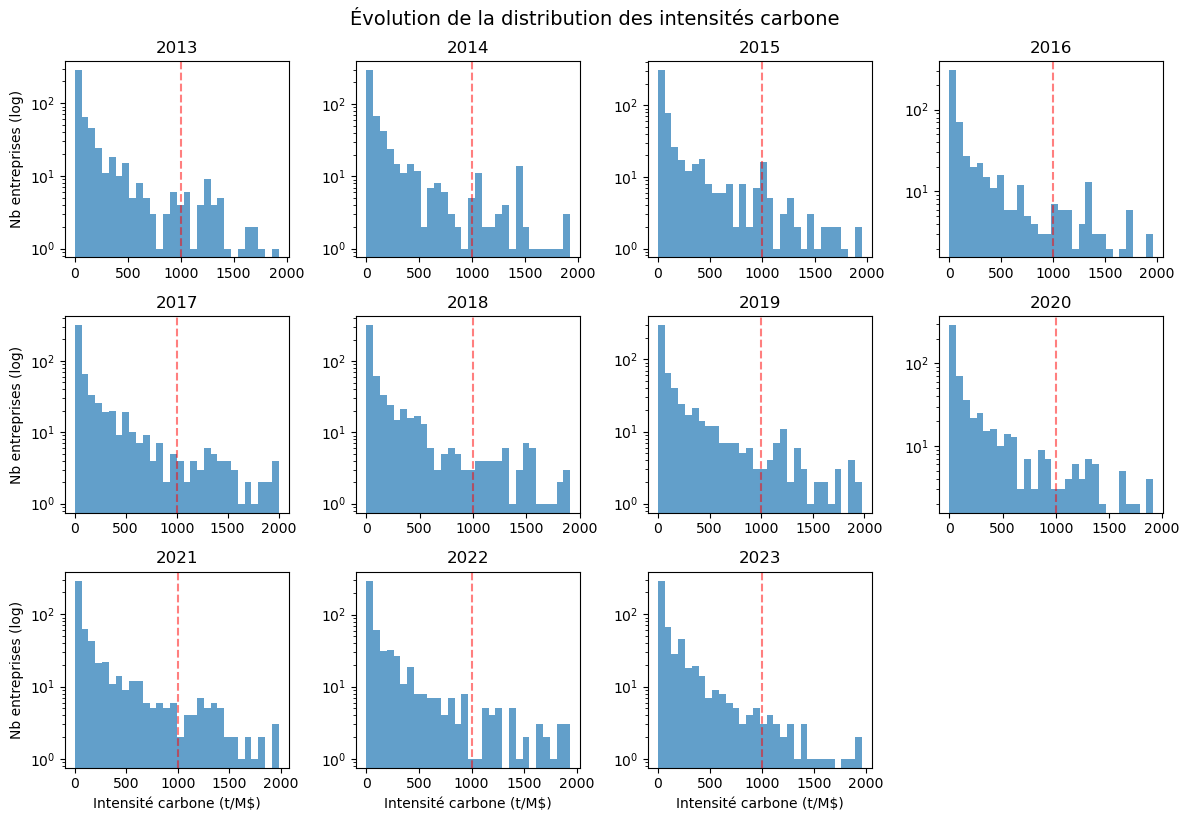

In [ ]:
# Créer un tableau récapitulatif pour toutes les années
years = range(2013, 2024)
summary = pd.DataFrame(index=years)

# Métrique 1: WACI
summary['WACI MV'] = pd.Series(waci_mv_annual)
summary['WACI VW'] = pd.Series(waci_vw_annual)
summary['WACI Ratio (MV/VW)'] = summary['WACI MV'] / summary['WACI VW']

# Métrique 2: Carbon Footprint
summary['CF MV'] = pd.Series(cf_mv_oos_annual)
summary['CF VW'] = pd.Series(cf_vw_annual)
summary['CF Ratio (MV/VW)'] = summary['CF MV'] / summary['CF VW']

# Métrique 3: Nombre de positions
for year in years:
    if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None:
        summary.loc[year, 'Positions MV'] = (all_optimal_weights_mv[year] > 0).sum()
    if year in all_benchmark_weights_vw and all_benchmark_weights_vw[year] is not None:
        summary.loc[year, 'Positions VW'] = (all_benchmark_weights_vw[year] > 0).sum()

# Métrique 4: Concentration (nombre effectif de titres)
for year in years:
    if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None:
        w = all_optimal_weights_mv[year]
        w_norm = w / w.sum()
        summary.loc[year, 'Effective N MV'] = 1 / (w_norm**2).sum()
    if year in all_benchmark_weights_vw and all_benchmark_weights_vw[year] is not None:
        w = all_benchmark_weights_vw[year]
        w_norm = w / w.sum()
        summary.loc[year, 'Effective N VW'] = 1 / (w_norm**2).sum()

# Afficher le tableau
print(summary.to_string(float_format='%.2f'))

# Évolution de la distribution des intensités carbone
plt.figure(figsize=(12, 8))

for i, year in enumerate(range(2013, 2024)):
    if year in carbon_intensity.columns:
        plt.subplot(3, 4, i+1)
        CI = carbon_intensity[year].dropna()
        CI[CI < 2000].hist(bins=30, log=True, alpha=0.7)
        plt.title(f"{year}")
        plt.axvline(1000, color='red', linestyle='--', alpha=0.5)
        if i >= 8:  # Ajouter les labels x uniquement sur la dernière ligne
            plt.xlabel("Intensité carbone (t/M$)")
        if i % 4 == 0:  # Ajouter les labels y uniquement sur la première colonne
            plt.ylabel("Nb entreprises (log)")
        plt.grid(False)

plt.tight_layout()
plt.suptitle("Évolution de la distribution des intensités carbone", y=1.02, fontsize=14)
plt.show()


# Corrélation entre volatilité et intensité carbone par année
correlations = []

for year in range(2013, 2024):
    if year in carbon_intensity.columns:
        CI = carbon_intensity[year].dropna()
        
        # Calculer les volatilités individuelles
        volatility = pd.Series(index=CI.index)
        for ticker in CI.index:
            if ticker in returns_cleaned.index:
                # Extraire les rendements des derniers 60 mois
                end_date = pd.to_datetime(f"{year}-12-31")
                start_date = end_date - pd.DateOffset(months=60)
                hist_cols = [col for col in returns_cleaned.columns 
                            if start_date <= pd.to_datetime(col) <= end_date]
                if len(hist_cols) >= 24:  # Au moins 2 ans de données
                    returns = returns_cleaned.loc[ticker, hist_cols].dropna()
                    if len(returns) >= 24:
                        volatility[ticker] = returns.std() * np.sqrt(12)
        
        # Filtrer pour garder uniquement les paires complètes
        common_assets = volatility.dropna().index.intersection(CI.index)
        vol_filtered = volatility.loc[common_assets]
        ci_filtered = CI.loc[common_assets]
        
        # Calculer la corrélation
        if len(common_assets) > 10:  # S'assurer d'avoir suffisamment de données
            corr = vol_filtered.corr(ci_filtered)
            correlations.append((year, corr, len(common_assets)))

# Afficher le tableau des corrélations
corr_df = pd.DataFrame(correlations, columns=['Année', 'Corrélation', 'N'])
print(corr_df)

# Visualiser l'évolution de la corrélation
plt.figure(figsize=(10, 6))
plt.plot(corr_df['Année'], corr_df['Corrélation'], 'o-')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.title("Évolution de la corrélation Volatilité-Intensité carbone")
plt.xlabel("Année")
plt.ylabel("Corrélation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Contribution cumulée à la WACI pour chaque année
plt.figure(figsize=(12, 8))

for i, year in enumerate(range(2013, 2024)):
    if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None and year in carbon_intensity.columns:
        plt.subplot(3, 4, i+1)
        
        w = all_optimal_weights_mv[year]
        CI = carbon_intensity[year]
        
        w_norm = w / w.sum()
        waci_contrib = w_norm * CI
        waci_contrib = waci_contrib.sort_values(ascending=False)
        
        # Calculer la contribution cumulée
        cum_contrib = (waci_contrib.cumsum() / waci_contrib.sum() * 100)
        cum_contrib = cum_contrib.iloc[:min(20, len(cum_contrib))]  # Limiter aux 20 premiers
        
        plt.plot(range(1, len(cum_contrib)+1), cum_contrib)
        plt.title(f"{year}")
        plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
        
        if i >= 8:  # Ajouter les labels x uniquement sur la dernière ligne
            plt.xlabel("Nombre de titres")
        if i % 4 == 0:  # Ajouter les labels y uniquement sur la première colonne
            plt.ylabel("% cumulé de la WACI")
        
        plt.grid(True, alpha=0.3)
        
        # Annoter le nombre de titres pour 50% de la WACI
        n50 = np.where(cum_contrib >= 50)[0][0] + 1 if any(cum_contrib >= 50) else "N/A"
        plt.text(0.7, 0.2, f"N50: {n50}", transform=plt.gca().transAxes)

plt.tight_layout()
plt.suptitle("Contribution cumulée à la WACI", y=1.02, fontsize=14)
plt.show()


# Évolution de la concentration du portefeuille
years = range(2013, 2024)
data = []

for year in years:
    if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None:
        w = all_optimal_weights_mv[year]
        w_norm = w / w.sum()
        
        # Métriques de concentration
        nnz = (w_norm > 0).sum()
        effective_n = 1 / (w_norm**2).sum()
        top5_weight = w_norm.sort_values(ascending=False).iloc[:5].sum() * 100
        gini = 1 - 2 * sum([(i+1)*w for i, w in enumerate(sorted(w_norm))]) / (nnz * sum(w_norm))
        
        data.append([year, nnz, effective_n, effective_n/nnz*100, top5_weight, gini])

conc_df = pd.DataFrame(data, columns=['Année', 'Positions', 'Effective N', 'Ratio E/P (%)', 'Top5 (%)', 'Gini'])
print(conc_df.to_string(float_format='%.2f'))

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(conc_df['Année'], conc_df['Positions'], 'o-', label='Positions')
plt.plot(conc_df['Année'], conc_df['Effective N'], 's-', label='Effective N')
plt.title("Nombre de positions vs Effective N")
plt.xlabel("Année")
plt.ylabel("Nombre de titres")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(conc_df['Année'], conc_df['Top5 (%)'], 'o-')
plt.title("Poids des 5 principales positions")
plt.xlabel("Année")
plt.ylabel("Poids Top5 (%)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Décomposition sectorielle (si vous avez des données sectorielles)
# Exemple de code si vous avez un DataFrame sector_data
if 'sector_data' in globals() and not sector_data.empty:
    # Créer un dataframe pour stocker les poids sectoriels
    sector_weights_mv = pd.DataFrame(index=sector_data['Sector'].unique(), columns=years)
    sector_weights_vw = pd.DataFrame(index=sector_data['Sector'].unique(), columns=years)
    
    for year in years:
        if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None:
            w_mv = all_optimal_weights_mv[year]
            w_vw = all_benchmark_weights_vw.get(year, pd.Series())
            
            for sector in sector_weights_mv.index:
                # Entreprises de ce secteur
                sector_companies = sector_data[sector_data['Sector'] == sector].index
                
                # Poids dans MV
                mv_weight = w_mv[w_mv.index.isin(sector_companies)].sum()
                sector_weights_mv.loc[sector, year] = mv_weight
                
                # Poids dans VW
                if not w_vw.empty:
                    vw_weight = w_vw[w_vw.index.isin(sector_companies)].sum()
                    sector_weights_vw.loc[sector, year] = vw_weight
    
    # Normaliser pour chaque année
    for year in years:
        if not sector_weights_mv[year].isnull().all():
            sector_weights_mv[year] = sector_weights_mv[year] / sector_weights_mv[year].sum() * 100
        if not sector_weights_vw[year].isnull().all():
            sector_weights_vw[year] = sector_weights_vw[year] / sector_weights_vw[year].sum() * 100
    
    # Calculer la différence moyenne
    sector_weights_mv['Moyenne'] = sector_weights_mv.mean(axis=1)
    sector_weights_vw['Moyenne'] = sector_weights_vw.mean(axis=1)
    
    diff = sector_weights_mv['Moyenne'] - sector_weights_vw['Moyenne']
    
    # Afficher les secteurs les plus surpondérés/sous-pondérés
    print("Différence moyenne de poids sectoriel (MV - VW):")
    print(diff.sort_values(ascending=False))


# Test de sensibilité pour chaque année
sensitivity_results = []

for year in range(2013, 2024):
    if year in all_optimal_weights_mv and all_optimal_weights_mv[year] is not None and year in carbon_intensity.columns:
        w = all_optimal_weights_mv[year]
        CI = carbon_intensity[year]
        
        # Calculer la WACI originale
        w_norm = w / w.sum()
        waci_original = (w_norm * CI).sum()
        
        # Identifier le plus gros contributeur
        waci_contrib = w_norm * CI
        top_polluter = waci_contrib.idxmax()
        top_contrib_value = waci_contrib[top_polluter]
        
        # Recalculer la WACI sans ce titre
        w_minus_top = w_norm.drop(top_polluter)
        w_minus_top = w_minus_top / w_minus_top.sum()  # Renormaliser
        CI_minus_top = CI.drop(top_polluter)
        waci_minus_top = (w_minus_top * CI_minus_top).sum()
        
        # Calculer l'impact
        impact_pct = (waci_original - waci_minus_top) / waci_original * 100
        
        sensitivity_results.append([
            year, 
            waci_original, 
            waci_minus_top, 
            impact_pct, 
            top_polluter, 
            w_norm[top_polluter]*100,
            CI[top_polluter],
            top_contrib_value,
            top_contrib_value/waci_original*100
        ])

sens_df = pd.DataFrame(sensitivity_results, columns=[
    'Année', 'WACI', 'WACI sans top', 'Impact (%)', 'Top polluer', 
    'Poids (%)', 'CI', 'Contribution', 'Contrib. (%)'
])

print(sens_df.to_string(float_format='%.2f'))

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(sens_df['Année'], sens_df['Impact (%)'], color='crimson', alpha=0.7)
plt.axhline(25, color='black', linestyle='--', alpha=0.5, label='Seuil critique (25%)')
plt.title("Impact du retrait du titre le plus polluant sur la WACI")
plt.xlabel("Année")
plt.ylabel("Réduction de la WACI (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Initialisation des dictionnaires pour le portefeuille avec contrainte carbone
all_optimal_weights_mv_carbon = {}
cf_mv_carbon_oos_annual = {}
waci_mv_carbon_annual = {}
monthly_returns_mv_carbon = {}

#Fonction pour optimiser le portefeuille à variance minimale avec contrainte carbone
def optimize_mv_with_carbon_constraint(cov_matrix, universe, carbon_data, market_cap_data, max_carbon_footprint):
   """
   Optimise un portefeuille avec contrainte d'empreinte carbone
   
   Parameters:
   -----------
   cov_matrix : pd.DataFrame
       Matrice de covariance des rendements
   universe : list ou pd.Index
       Liste des ISIN dans l'univers d'investissement
   carbon_data : pd.Series
       Émissions totales de carbone (index=ISIN)
   market_cap_data : pd.Series
       Capitalisation boursière (index=ISIN)
   max_carbon_footprint : float
       Empreinte carbone maximale autorisée (50% de celle du portefeuille MV original)
   
   Returns:
   --------
   tuple
       (poids optimaux, empreinte carbone atteinte)
   """
   # S'assurer que la matrice de covariance utilise le même univers et ordre
   cov_matrix = cov_matrix.loc[universe, universe]
   n_assets = len(cov_matrix)
   
   # Fonction objective: variance du portefeuille
   def portfolio_variance(weights):
       return weights @ cov_matrix @ weights
   
   # Contrainte: somme des poids = 1
   def sum_constraint(weights):
       return np.sum(weights) - 1
   
   # Rendre la contrainte carbone plus lisible
   def carbon_constraint(weights):
       # Normaliser les poids
       weights_norm = weights / np.sum(weights)
       
       # Calculer l'empreinte carbone du portefeuille
       portfolio_value = 1  # 1 million USD investis
       
       # Aligner les poids, émissions et capitalisations
       common_assets = cov_matrix.index.intersection(carbon_data.index).intersection(market_cap_data.index)
       
       if len(common_assets) == 0:
           return max_carbon_footprint  # Pas de données communes, contrainte satisfaite
       
       # Filtrer les données pour les actifs communs
       w_subset = pd.Series(weights_norm, index=cov_matrix.index)[common_assets].values
       e_subset = carbon_data.loc[common_assets].values
       cap_subset = market_cap_data.loc[common_assets].values
       
       # Filtrer les valeurs valides
       valid_idx = (~np.isnan(e_subset)) & (cap_subset > 0)
       
       if not np.any(valid_idx):
           return max_carbon_footprint  # Pas de données valides, contrainte satisfaite
       
       w_valid = w_subset[valid_idx]
       e_valid = e_subset[valid_idx]
       cap_valid = cap_subset[valid_idx]
       
       # Si tous les poids valides sont nuls, la contrainte est satisfaite par défaut
       if np.sum(w_valid) == 0:
           return max_carbon_footprint
       
       # Normaliser les poids valides
       w_valid = w_valid / np.sum(w_valid)
       
       # Calculer l'empreinte carbone selon la formule du projet
       ownership = (w_valid * portfolio_value) / cap_valid
       cf = (1 / portfolio_value) * np.sum(ownership * e_valid)
       
       # Contrainte plus lisible: max_carbon_footprint - cf doit être ≥ 0
       return max_carbon_footprint - cf
   
   # Contraintes
   constraints = [
       {'type': 'eq', 'fun': sum_constraint},
       {'type': 'ineq', 'fun': carbon_constraint}  # Contrainte lisible: max_carbon_footprint - cf ≥ 0
   ]
   
   # Bornes: poids ≥ 0 (long-only)
   bounds = tuple((0, None) for _ in range(n_assets))
   
   # Point de départ: poids égaux
   init_weights = np.ones(n_assets) / n_assets
   
   # Optimisation
   try:
       result = minimize(
           portfolio_variance,
           init_weights,
           method='SLSQP',
           bounds=bounds,
           constraints=constraints,
           options={'ftol': 1e-9, 'maxiter': 1000}
       )
       
       if result.success:
           # Créer une Series avec le bon index (ISIN)
           optimal_weights = pd.Series(result.x, index=cov_matrix.index)
           
           # Éliminer les poids très faibles
           optimal_weights[optimal_weights < 1e-8] = 0
           
           # Normaliser les poids
           if optimal_weights.sum() > 0:
               optimal_weights = optimal_weights / optimal_weights.sum()
           
           # Calculer l'empreinte carbone atteinte
           # On doit recalculer car la contrainte est dans l'autre sens maintenant
           achieved_cf_diff = carbon_constraint(result.x)
           achieved_cf = max_carbon_footprint - achieved_cf_diff
           
           return optimal_weights, achieved_cf
       else:
           print(f"Échec de l'optimisation: {result.message}")
           return None, None
   except Exception as e:
       print(f"Erreur lors de l'optimisation: {e}")
       return None, None

# Années d'allocation
years = sorted([year for year in all_optimal_weights_mv.keys() if all_optimal_weights_mv[year] is not None])

# Pour chaque année
for year in years:
   print(f"\n=== Construction du portefeuille MV avec contrainte carbone pour {year+1} ===")
   
   # Récupérer l'empreinte carbone de référence
   if year not in cf_mv_oos_annual or np.isnan(cf_mv_oos_annual[year]):
       print(f"Pas d'empreinte carbone de référence pour {year}. Passage à l'année suivante.")
       all_optimal_weights_mv_carbon[year] = None
       cf_mv_carbon_oos_annual[year] = np.nan
       waci_mv_carbon_annual[year] = np.nan
       continue
   
   # Empreinte carbone maximale autorisée (50% de celle du portefeuille MV)
   max_carbon_footprint = 0.5 * cf_mv_oos_annual[year]
   print(f"Empreinte carbone de référence: {cf_mv_oos_annual[year]:.4f}")
   print(f"Empreinte carbone maximale autorisée (50%): {max_carbon_footprint:.4f}")
   
   # Récupérer la matrice de covariance
   # On doit recalculer la matrice de covariance pour cette année
   end_date = pd.to_datetime(f"{year}-12-31")
   start_date = pd.to_datetime(f"{year-10+1}-01-01")
   hist_cols = [col for col in returns_cleaned.columns
               if start_date <= pd.to_datetime(col) <= end_date]
   
   # Utiliser le même univers que le portefeuille MV original
   universe_mv = all_optimal_weights_mv[year].index
   returns_hist = returns_cleaned.loc[universe_mv, hist_cols]
   
   # Calculer la matrice de covariance
   returns_for_cov = returns_hist.T
   cov_matrix = returns_for_cov.cov(ddof=0)
   
   # Régularisation de la matrice (comme dans le code des portefeuilles originaux)
   sigma_bar = np.trace(cov_matrix) / len(cov_matrix)
   max_bias_ratio = ridge_param  # Utiliser le même paramètre de ridge que pour les portefeuilles originaux
   lambda_ = max_bias_ratio * sigma_bar
   cov_matrix_reg = cov_matrix + np.eye(len(cov_matrix)) * lambda_
   
   # Affichage des informations sur la régularisation
   kappa = np.linalg.cond(cov_matrix_reg)
   bias_ratio = lambda_ / sigma_bar
   
   print(f"cond(Σ régularisée): {kappa:.2e}")
   print(f"Biais relatif (λ/σ̄²): {bias_ratio:.1%}")
   
   # Récupérer les données d'émissions carbone
   if year not in total_emissions.columns:
       print(f"Pas de données d'émissions pour {year}. Passage à l'année suivante.")
       all_optimal_weights_mv_carbon[year] = None
       cf_mv_carbon_oos_annual[year] = np.nan
       waci_mv_carbon_annual[year] = np.nan
       continue
   
   emissions_y = total_emissions[year]
   
   # Récupérer les données de capitalisation boursière
   # Trouver la date la plus proche de la fin de l'année
   closest_date = None
   target_date = f"{year}-12-31"
   
   for col in market_cap_m_em.columns:
       if col not in ['ISIN', 'NAME']:
           try:
               col_date = pd.to_datetime(col)
               if closest_date is None or abs((col_date - pd.to_datetime(target_date)).days) < abs((pd.to_datetime(closest_date) - pd.to_datetime(target_date)).days):
                   closest_date = col
           except:
               continue
   
   if closest_date is None:
       print(f"Pas de données de capitalisation pour {year}. Passage à l'année suivante.")
       all_optimal_weights_mv_carbon[year] = None
       cf_mv_carbon_oos_annual[year] = np.nan
       waci_mv_carbon_annual[year] = np.nan
       continue
   
   market_cap_end = market_cap_m_em.set_index('ISIN')[closest_date] if 'ISIN' in market_cap_m_em.columns else market_cap_m_em[closest_date]
   
   # Optimiser le portefeuille avec contrainte carbone
   optimal_weights, achieved_cf = optimize_mv_with_carbon_constraint(
       cov_matrix_reg,
       universe_mv,
       emissions_y,
       market_cap_end,
       max_carbon_footprint
   )
   
   if optimal_weights is None:
       print(f"Échec de l'optimisation pour {year}. Passage à l'année suivante.")
       all_optimal_weights_mv_carbon[year] = None
       cf_mv_carbon_oos_annual[year] = np.nan
       waci_mv_carbon_annual[year] = np.nan
       continue
   
   # Stocker les résultats
   all_optimal_weights_mv_carbon[year] = optimal_weights
   cf_mv_carbon_oos_annual[year] = achieved_cf
   
   # Statistiques du portefeuille
   active_assets = (optimal_weights > 0).sum()
   print(f"Poids optimaux calculés: {active_assets} titres actifs")
   print(f"Empreinte carbone atteinte: {achieved_cf:.4f} (Réduction: {(1 - achieved_cf/cf_mv_oos_annual[year])*100:.1f}%)")
   
   # Calculer la WACI du portefeuille
   if year in carbon_intensity.columns:
       intensity_y = carbon_intensity[year]
       
       # Aligner les poids et les intensités carbone
       common_assets = optimal_weights.index.intersection(intensity_y.index)
       
       if len(common_assets) > 0:
           w_carbon = optimal_weights.loc[common_assets]
           ci_carbon = intensity_y.loc[common_assets]
           
           # Filtrer les valeurs valides
           valid_idx = ci_carbon.notna()
           
           if valid_idx.any():
               w_valid = w_carbon[valid_idx]
               ci_valid = ci_carbon[valid_idx]
               
               # Normaliser les poids
               w_valid = w_valid / w_valid.sum()
               
               # Calculer la WACI
               waci_carbon = (w_valid * ci_valid).sum()
               
               waci_mv_carbon_annual[year] = waci_carbon
               print(f"WACI: {waci_carbon:.4f}")
           else:
               waci_mv_carbon_annual[year] = np.nan
               print("Pas de données valides pour calculer la WACI")
       else:
           waci_mv_carbon_annual[year] = np.nan
           print("Pas de données communes pour calculer la WACI")
   else:
       waci_mv_carbon_annual[year] = np.nan
       print(f"Pas de données d'intensité carbone pour {year}")

# Calcul des rendements ex-post
print("\n=== Calcul des rendements ex-post pour le portefeuille avec contrainte carbone ===")

# Période de performance
performance_start = pd.to_datetime("2014-01-01")
date_cols = [col for col in returns_cleaned.columns if pd.to_datetime(col) >= performance_start]
date_cols.sort()

if len(date_cols) > 0:
   # Initialiser la série de rendements cumulés
   cum_returns_mv_carbon = pd.Series(index=date_cols, dtype=float)
   cum_returns_mv_carbon.iloc[0] = 1.0
   
   # Pour chaque année de performance
   for year_perf in range(2014, 2025):
       # Identifier l'année d'allocation précédente
       year_alloc = year_perf - 1
       
       # Récupérer les poids pour cette allocation
       mv_carbon_weights = all_optimal_weights_mv_carbon.get(year_alloc)
       
       # Colonnes (mois) pour cette année de performance
       perf_cols = [col for col in date_cols 
                   if pd.to_datetime(col).year == year_perf]
       
       # Calcul des rendements du portefeuille
       if mv_carbon_weights is not None and len(perf_cols) > 0:
           # Commencer avec les poids initiaux pour l'année
           current_weights = mv_carbon_weights.copy()
           num_assets = len(mv_carbon_weights[mv_carbon_weights > 0])
           
           print(f"\n· Performance MV avec contrainte carbone pour {year_perf} (titres actifs: {num_assets})")
           
           for month in perf_cols:
               # Identifier les actifs communs entre les poids et les rendements
               common_assets = current_weights.index.intersection(returns_cleaned.index)
               
               if len(common_assets) == 0:
                   print(f"  · Aucun actif commun pour {month}")
                   monthly_returns_mv_carbon[month] = np.nan
                   continue
               
               # Filtrer pour les actifs communs
               filtered_weights = current_weights.loc[common_assets]
               month_returns = returns_cleaned.loc[common_assets, month]
               
               # Éliminer les NaN dans les rendements
               valid_mask = month_returns.notna()
               valid_assets = common_assets[valid_mask]
               
               if len(valid_assets) == 0:
                   print(f"  · Aucun rendement valide pour {month}")
                   monthly_returns_mv_carbon[month] = np.nan
                   continue
               
               # Recalculer les poids pour les actifs valides seulement
               valid_weights = filtered_weights.loc[valid_assets]
               w_sum = valid_weights.sum()
               
               if w_sum <= 0:
                   print(f"  · Somme des poids nulle pour {month}")
                   monthly_returns_mv_carbon[month] = np.nan
                   continue
               
               # Normaliser les poids
               valid_weights = valid_weights / w_sum
               
               # Récupérer les rendements pour ce mois
               valid_returns = month_returns.loc[valid_assets]
               
               # Calculer le rendement du portefeuille
               port_return_carbon = (valid_weights * valid_returns).sum()
               monthly_returns_mv_carbon[month] = port_return_carbon
               
               # Mettre à jour les poids pour le mois suivant (rebalancement dynamique)
               updated_weights = valid_weights * (1 + valid_returns)
               current_weights = pd.Series(0, index=current_weights.index, dtype=float)
               current_weights.loc[valid_assets] = updated_weights
               current_weights = current_weights / current_weights.sum()
               
               month_date = pd.to_datetime(month)
               month_str = f"{month_date.year}-{month_date.month:02d}"
               print(f"  · {month_str}: R={port_return_carbon:.4f} (Actifs: {len(valid_assets)})")
   
   # Convertir les rendements mensuels en série
   returns_mv_carbon_series = pd.Series(monthly_returns_mv_carbon)
   
   # Gérer les dates manquantes pour le calcul des rendements cumulés
   # Pour le calcul des rendements cumulés, on remplit les NaN par 0 (aucun rendement)
   returns_mv_carbon_filled = returns_mv_carbon_series.fillna(0)
   
   # Calculer les rendements cumulés
   cum_returns_mv_carbon = (1 + returns_mv_carbon_filled).cumprod()
   
   # Récupérer les séries de rendements des portefeuilles MV et VW d'origine pour comparaison
   returns_mv_series = pd.Series(monthly_returns_mv)
   returns_vw_series = pd.Series(monthly_returns_vw)
   
   # Appliquer le même traitement aux autres séries pour cohérence
   returns_mv_filled = returns_mv_series.fillna(0)
   returns_vw_filled = returns_vw_series.fillna(0)
   
   cum_returns_mv = (1 + returns_mv_filled).cumprod()
   cum_returns_vw = (1 + returns_vw_filled).cumprod()
   
   # Analyse des performances
   print("\n=== Analyse des performances du portefeuille avec contrainte carbone ===")
   
   # Calculer les statistiques pour tous les portefeuilles
   stats_mv_carbon = calculate_performance_stats(returns_mv_carbon_series, annualized_rf_rate)
   stats_mv = calculate_performance_stats(returns_mv_series, annualized_rf_rate)
   stats_vw = calculate_performance_stats(returns_vw_series, annualized_rf_rate)
   
   # Affichage des statistiques comparatives
  print("\n· Statistiques de performance comparatives:")
   print(f"  · Taux sans risque annualisé: {annualized_rf_rate:.4f}")
   
   print("\n· Portefeuille MV avec contrainte carbone (50%):")
   print(f"  · Rendement annualisé: {stats_mv_carbon['annualized_return']:.4f}")
   print(f"  · Volatilité annualisée: {stats_mv_carbon['annualized_volatility']:.4f}")
   print(f"  · Ratio de Sharpe: {stats_mv_carbon['sharpe_ratio']:.4f}")
   print(f"  · Rendement mensuel min: {stats_mv_carbon['min']:.4f}")
   print(f"  · Rendement mensuel max: {stats_mv_carbon['max']:.4f}")
   
   print("\n· Portefeuille MV original (pour comparaison):")
   print(f"  · Rendement annualisé: {stats_mv['annualized_return']:.4f}")
   print(f"  · Volatilité annualisée: {stats_mv['annualized_volatility']:.4f}")
   print(f"  · Ratio de Sharpe: {stats_mv['sharpe_ratio']:.4f}")
   
   print("\n· Portefeuille VW (pour comparaison):")
   print(f"  · Rendement annualisé: {stats_vw['annualized_return']:.4f}")
   print(f"  · Volatilité annualisée: {stats_vw['annualized_volatility']:.4f}")
   print(f"  · Ratio de Sharpe: {stats_vw['sharpe_ratio']:.4f}")
   
   # Graphique des rendements cumulés
   plt.figure(figsize=(12, 6))
   plt.plot(cum_returns_mv.index, cum_returns_mv, label='MV original')
   plt.plot(cum_returns_mv_carbon.index, cum_returns_mv_carbon, label='MV avec contrainte carbone (50%)')
   plt.plot(cum_returns_vw.index, cum_returns_vw, label='VW')
   plt.title('Rendements cumulés (2014-2024)')
   plt.xlabel('Date')
   plt.ylabel('Rendement cumulé (départ à 1)')
   plt.grid(True)
   plt.legend()
   plt.tight_layout()
   plt.savefig('cumulative_returns_with_carbon_constraint.png')
   plt.close()
   
   print("\n· Graphique des rendements cumulés enregistré sous 'cumulative_returns_with_carbon_constraint.png'")
   
   # Graphique comparatif des empreintes carbone
   cf_mv_series = pd.Series(cf_mv_oos_annual)
   cf_vw_series = pd.Series(cf_vw_annual)
   cf_mv_carbon_series = pd.Series(cf_mv_carbon_oos_annual)
   
   plt.figure(figsize=(10, 6))
   plt.plot(cf_mv_series.index, cf_mv_series, marker='o', label='MV original')
   plt.plot(cf_mv_carbon_series.index, cf_mv_carbon_series, marker='s', label='MV avec contrainte carbone (50%)')
   plt.plot(cf_vw_series.index, cf_vw_series, marker='^', label='VW')
   plt.title('Empreinte carbone des portefeuilles (2013-2023)')
   plt.xlabel('Année')
   plt.ylabel('Empreinte carbone (tCO2e/$M investi)')
   plt.grid(True)
   plt.legend()
   plt.tight_layout()
   plt.savefig('carbon_footprint_comparison_with_constraint.png')
   plt.close()
   
   print("\n· Graphique comparatif des empreintes carbone enregistré sous 'carbon_footprint_comparison_with_constraint.png'")
   
   # Analyse du coût de la contrainte carbone
   common_dates = returns_mv_series.index.intersection(returns_mv_carbon_series.index)
   if len(common_dates) > 0:
       # Calculer les statistiques de tracking error
       tracking_diff = returns_mv_carbon_series[common_dates] - returns_mv_series[common_dates]
       tracking_error = tracking_diff.std() * np.sqrt(12)  # Annualisé
       
       # Rendement excédentaire annualisé
       excess_return = stats_mv_carbon['annualized_return'] - stats_mv['annualized_return']
       
       # Ratio d'information
       information_ratio = excess_return / tracking_error if tracking_error > 0 else np.nan
       
       print("\n· Analyse du coût de la contrainte carbone:")
       print(f"  · Tracking error annualisé: {tracking_error:.4f}")
       print(f"  · Rendement excédentaire annualisé: {excess_return:.4f}")
       print(f"  · Ratio d'information: {information_ratio:.4f}")
   
   # Graphique comparatif des WACI
   waci_mv_series = pd.Series(waci_mv_annual)
   waci_vw_series = pd.Series(waci_vw_annual)
   waci_mv_carbon_series = pd.Series(waci_mv_carbon_annual)
   
   plt.figure(figsize=(10, 6))
   plt.plot(waci_mv_series.index, waci_mv_series, marker='o', label='MV original')
   plt.plot(waci_mv_carbon_series.index, waci_mv_carbon_series, marker='s', label='MV avec contrainte carbone (50%)')
   plt.plot(waci_vw_series.index, waci_vw_series, marker='^', label='VW')
   plt.title('WACI des portefeuilles (2013-2023)')
   plt.xlabel('Année')
   plt.ylabel('WACI (tCO2e/$M revenu)')
   plt.grid(True)
   plt.legend()
   plt.tight_layout()
   plt.savefig('waci_comparison_with_constraint.png')
   plt.close()
   
   print("\n· Graphique comparatif des WACI enregistré sous 'waci_comparison_with_constraint.png'")
   
   # Analyse statistique comparative complète
   print("\n=== Récapitulatif des performances et mesures d'impact carbone ===")
   
   # Créer un DataFrame pour résumer les statistiques
   summary_df = pd.DataFrame({
       'MV Original': [
           stats_mv['annualized_return'],
           stats_mv['annualized_volatility'],
           stats_mv['sharpe_ratio'],
           cf_mv_series.mean(),
           waci_mv_series.mean()
       ],
       'MV Contrainte Carbone (50%)': [
           stats_mv_carbon['annualized_return'],
           stats_mv_carbon['annualized_volatility'],
           stats_mv_carbon['sharpe_ratio'],
           cf_mv_carbon_series.mean(),
           waci_mv_carbon_series.mean()
       ],
       'VW': [
           stats_vw['annualized_return'],
           stats_vw['annualized_volatility'],
           stats_vw['sharpe_ratio'],
           cf_vw_series.mean(),
           waci_vw_series.mean()
       ]
   }, index=[
       'Rendement annualisé',
       'Volatilité annualisée',
       'Ratio de Sharpe',
       'Empreinte carbone moyenne',
       'WACI moyenne'
   ])
   
   # Ajouter les réductions relatives en % (par rapport au VW)
   reduction_mv_vs_vw = pd.Series({
       'Rendement annualisé': (stats_mv['annualized_return'] - stats_vw['annualized_return']) / abs(stats_vw['annualized_return']) * 100 if stats_vw['annualized_return'] != 0 else np.nan,
       'Volatilité annualisée': (1 - stats_mv['annualized_volatility'] / stats_vw['annualized_volatility']) * 100,
       'Ratio de Sharpe': (stats_mv['sharpe_ratio'] - stats_vw['sharpe_ratio']) / abs(stats_vw['sharpe_ratio']) * 100 if stats_vw['sharpe_ratio'] != 0 else np.nan,
       'Empreinte carbone moyenne': (1 - cf_mv_series.mean() / cf_vw_series.mean()) * 100,
       'WACI moyenne': (1 - waci_mv_series.mean() / waci_vw_series.mean()) * 100
   })
   
   reduction_carbon_vs_vw = pd.Series({
       'Rendement annualisé': (stats_mv_carbon['annualized_return'] - stats_vw['annualized_return']) / abs(stats_vw['annualized_return']) * 100 if stats_vw['annualized_return'] != 0 else np.nan,
       'Volatilité annualisée': (1 - stats_mv_carbon['annualized_volatility'] / stats_vw['annualized_volatility']) * 100,
       'Ratio de Sharpe': (stats_mv_carbon['sharpe_ratio'] - stats_vw['sharpe_ratio']) / abs(stats_vw['sharpe_ratio']) * 100 if stats_vw['sharpe_ratio'] != 0 else np.nan,
       'Empreinte carbone moyenne': (1 - cf_mv_carbon_series.mean() / cf_vw_series.mean()) * 100,
       'WACI moyenne': (1 - waci_mv_carbon_series.mean() / waci_vw_series.mean()) * 100
   })
   
   summary_df['MV vs VW (%)'] = reduction_mv_vs_vw
   summary_df['MV Carbon vs VW (%)'] = reduction_carbon_vs_vw
   
   # Calculer le coût de la contrainte carbone (différence entre MV Carbon et MV Original)
   cost_of_carbon_constraint = pd.Series({
       'Rendement annualisé': stats_mv_carbon['annualized_return'] - stats_mv['annualized_return'],
       'Volatilité annualisée': stats_mv_carbon['annualized_volatility'] - stats_mv['annualized_volatility'],
       'Ratio de Sharpe': stats_mv_carbon['sharpe_ratio'] - stats_mv['sharpe_ratio'],
       'Empreinte carbone moyenne': cf_mv_carbon_series.mean() - cf_mv_series.mean(),
       'WACI moyenne': waci_mv_carbon_series.mean() - waci_mv_series.mean()
   })
   
   summary_df['Coût de la contrainte'] = cost_of_carbon_constraint
   
   # Ajouter le ratio d'information
   summary_df.loc['Ratio d\'information', 'MV Contrainte Carbone (50%)'] = information_ratio
   
   # Afficher le tableau récapitulatif
   print("\n· Tableau récapitulatif des performances et mesures d'impact:")
   
   # Formater le tableau pour un affichage plus lisible
   pd.set_option('display.float_format', '{:.4f}'.format)
   print(summary_df)
   
   # Conclusion
   print("\n=== Conclusion ===")
   carbon_reduction = (1 - cf_mv_carbon_series.mean() / cf_mv_series.mean()) * 100
   waci_reduction = (1 - waci_mv_carbon_series.mean() / waci_mv_series.mean()) * 100
   sharpe_change = (stats_mv_carbon['sharpe_ratio'] / stats_mv['sharpe_ratio'] - 1) * 100 if stats_mv['sharpe_ratio'] != 0 else np.nan
   
   print(f"La stratégie avec contrainte carbone a réduit l'empreinte carbone de {carbon_reduction:.1f}% et la WACI de {waci_reduction:.1f}%")
   print(f"par rapport au portefeuille à variance minimale original. Le ratio de Sharpe a {'augmenté' if sharpe_change >= 0 else 'diminué'} de {abs(sharpe_change):.1f}%.")
   print(f"Le ratio d'information de {information_ratio:.4f} montre que la contrainte carbone {'a un impact positif' if information_ratio > 0 else 'a un coût'} sur la performance ajustée au risque.")
   
   return_diff = (stats_mv_carbon['annualized_return'] - stats_mv['annualized_return']) * 100
   vol_diff = (stats_mv_carbon['annualized_volatility'] - stats_mv['annualized_volatility']) * 100
   
   print(f"Le coût de la contrainte carbone se traduit par une différence de rendement annualisé de {return_diff:.2f}% et")
   print(f"une différence de volatilité annualisée de {vol_diff:.2f}%.")
   
   # Recommandation finale
   print("\n· Recommandation finale:")
   if information_ratio > 0:
       print("La contrainte d'empreinte carbone offre un profil risque-rendement ajusté favorable tout en réduisant")
       print("significativement l'impact environnemental du portefeuille. Cette approche est recommandée pour les")
       print("investisseurs souhaitant concilier performance financière et objectifs de durabilité.")
   elif information_ratio > -0.1:  # Seuil arbitraire proche de zéro
       print("La contrainte d'empreinte carbone permet de réduire significativement l'impact environnemental")
       print("avec un coût modéré en termes de performance ajustée au risque. Cette approche représente un")
       print("compromis raisonnable entre objectifs financiers et environnementaux.")
   else:
       print("La contrainte d'empreinte carbone entraîne un coût significatif en termes de performance ajustée")
       print("au risque. Cette approche est recommandée uniquement pour les investisseurs privilégiant fortement")
       print("les objectifs environnementaux par rapport à la performance financière.")
else:
   print("Pas de données de performance disponibles.")

IndentationError: unindent does not match any outer indentation level (<string>, line 388)